In [12]:
import torch
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import residual_GAN
from image_dataset import image_dataset
from torch.utils.data import RandomSampler
from torch_snippets import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
path = r"resnet_300M/run11/"
discriminator = residual_GAN.Discriminator().to(device)
discriminator.load_state_dict(torch.load(path+"discriminator.pth"))
generator = residual_GAN.Generator(noise_dim=2048).to(device)
generator.load_state_dict(torch.load(path+"generator.pth"))

<All keys matched successfully>

# Data Pipeline and Utility Functions

In [14]:
def noise_generator(device,batch_size=64, dimension=2048):
    return torch.randn((batch_size, dimension)).to(device)

In [15]:
img_transforms = transforms.Compose([
    transforms.Resize([128,128]),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    #transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
folder = "../../Datasets/annotated_img/images/train2017"
train_dataset = image_dataset(folder,img_transforms)
batch_size = 64
num_samples = 19200
train_sampler = RandomSampler(train_dataset,replacement=False,num_samples=num_samples)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)

# training routine

In [16]:
model_name = "resnet_300M_discriminator"
if not os.path.exists(model_name):
    os.makedirs(model_name)

In [17]:
def train_discriminator(discriminator, real_data, fake_data, loss_fn, optimizer,real_factor=3):
    optimizer.zero_grad()
    pred_real = discriminator(real_data)
    loss_real = loss_fn(pred_real, torch.ones((len(real_data),1)).to(device))
    pred_fake = discriminator(fake_data)
    loss_fake = loss_fn(pred_fake, torch.zeros((len(fake_data),1)).to(device))
    loss = loss_real * real_factor + loss_fake
    loss.backward()
    optimizer.step()
    return loss_real, loss_fake

In [18]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(discriminator.parameters(),lr=1e-5)

# training discriminator

EPOCH: 1.000  loss_real: 0.134  total_loss: 0.792  loss_fake: 0.658  (171.06s - 1539.51s remaining)
EPOCH: 2.000  loss_real: 0.038  total_loss: 0.207  loss_fake: 0.168  (335.62s - 1342.47s remaining)
EPOCH: 3.000  loss_real: 0.013  total_loss: 0.068  loss_fake: 0.055  (498.97s - 1164.27s remaining)
EPOCH: 4.000  loss_real: 0.007  total_loss: 0.036  loss_fake: 0.029  (683.16s - 1024.74s remaining)
EPOCH: 5.000  loss_real: 0.005  total_loss: 0.022  loss_fake: 0.017  (864.92s - 864.92s remaining))


100%|██████████| 111/111 [00:00<00:00, 3568.17it/s]


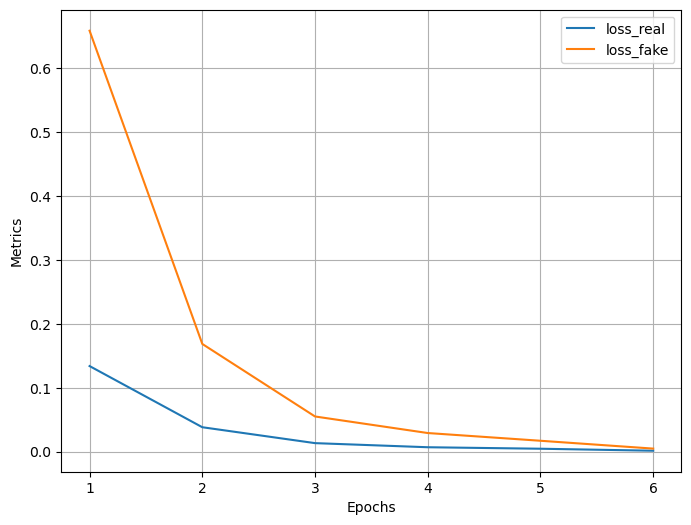

In [19]:
N = len(train_dataloader)
noise_dim = 2048
num_epochs = 10
threshold = 0.05
log = Report(num_epochs)
discriminator.to(device)
loss_total = 0
num_batchs = 0
count = 0

for epoch in range(num_epochs):
    for idx, imgs in enumerate(train_dataloader):
        real_data = imgs.to(device)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        fake_data = fake_data.detach()
        loss_real, loss_fake = train_discriminator(discriminator,real_data,fake_data,loss_fn,optimizer,4)
        total_loss = loss_real.item() + loss_fake.item()
        num_batchs += 1
        loss_total += total_loss
        log.record(epoch+(1+idx)/N, total_loss = total_loss, loss_real = loss_real.item(),
                   loss_fake = loss_fake.item(), end = '\r')
    log.report_avgs(epoch+1)
    if (loss_total/num_batchs) < threshold:
        count += 1
        if count == 2:
            torch.save(discriminator.state_dict(),model_name+"/discriminator.pth")
            break
    else:
        count = 0
    loss_total = 0
    num_batchs = 0
log.plot_epochs(['loss_real','loss_fake'])
    
